# Imports

In [1]:
## Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    force=True
)

## Numeric imports
import pandas as pd

## File I/O
from pathlib import Path
import json

## Cheminformatics
from rdkit import Chem

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:rdkit:Enabling RDKit 2023.03.3 jupyter extensions


# Param input

In [2]:
mono_data_path : Path = Path('processed_monomer_data') / 'clean_smarts_digroup.csv'
rxn_mech_dir   : Path = Path('rxn_smarts')

rxns_from_smarts : bool = True#False

## Load processed monomer starting structures

In [3]:
logging.info(f'Loading processed data from {mono_data_path.stem}')
digroup_table = pd.read_csv(mono_data_path, index_col=[0])
tables_by_chem = {
    chemistry : digroup_table[digroup_table['Chemistry'] == chemistry].dropna(axis=1).reset_index(drop=True)
        for chemistry in set(digroup_table['Chemistry'])
}

INFO:root:Loading processed data from clean_smarts_digroup


## Load rxn mechanisms

In [4]:
from polymerist.rdutils.reactions import reactions, reactors


reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

logging.info(f'Loading reaction mechanisms (from {"SMARTS" if rxns_from_smarts else "MDL files"})')
if rxns_from_smarts:
    with (rxn_mech_dir / 'rxn_smarts.json').open('r') as rxn_file:
        rxns = {
            chemistry : reactions.AnnotatedReaction.from_smarts(rxn_SMARTS)
                for chemistry, rxn_SMARTS in json.load(rxn_file).items()
        }
else:
    # from files
    rxns = {
        chemistry : reactions.AnnotatedReaction.from_rxnfile(rxn_mech_dir / f'{chemistry}.rxn')
            for chemistry in reaction_pairs.keys()
    }

INFO:polymerist.monomers.substruct.functgroups:Loading functional group SMARTS data from LUT
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.fl

INFO:root:Loading reaction mechanisms (from SMARTS)


# Polymerizing fragments

## Example for polymerization of individual molecule

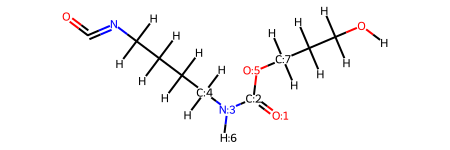

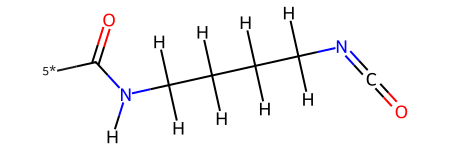

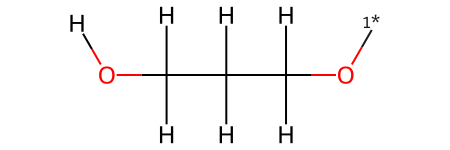

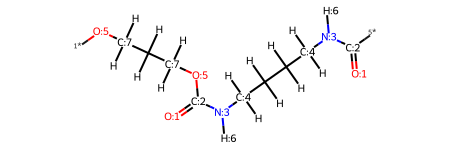

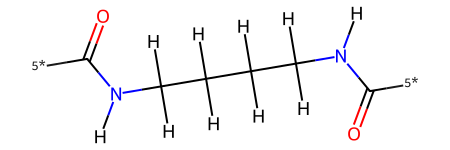

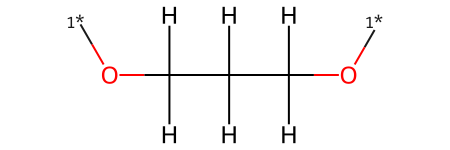

In [5]:
chemistry = 'urethane'
idx = 3

rxn_pathway = rxns[chemistry]
chem_tab = tables_by_chem[chemistry]
chem_entry = chem_tab.loc[idx]

reactants = {
    react_name : Chem.MolFromSmarts(chem_entry[react_name])
        for react_name in reaction_pairs[chemistry]
}

reactor = reactors.PolymerizationReactor(rxn_pathway)
for (dimer, pair) in reactor.propagate([i for i in reactants.values()]):
    display(dimer)
    for frag in pair:
        display(frag)
    print('='*50)

## Polymerize all SMILES into well-specified fragments with ports

In [ ]:
from polymerist.monomers import MonomerGroup
from polymerist.monomers.substruct import specification
from polymerist.rdutils.labeling import molwise


mono_info_dir  : Path = Path('monomer_files_dup')
mono_info_dir.mkdir(exist_ok=True)

for chemistry, smarts_table in tables_by_chem.items():
    chem_dir = mono_info_dir / chemistry
    chem_dir.mkdir(exist_ok=True)

    for i, sample in smarts_table.iterrows():
        logging.info(f'Generating fragments for {chemistry} #{i}')
        # look up reactive groups and pathway by chemistry
        rxn_group_names = reaction_pairs[chemistry]
        rxn = rxns[chemistry]

        # read reactant monomers from digroup_table
        initial_reactants = []
        for j, group_name in enumerate(rxn_group_names):
            reactant = Chem.MolFromSmiles(sample[group_name], sanitize=False)
            for atom in reactant.GetAtoms():
                atom.SetProp('reactant_group', group_name)
            
            initial_reactants.append(reactant)
        monogrp = MonomerGroup()

        # first round of polymerization (initiation)
        reactor = reactors.PolymerizationReactor(rxn)
        for dimer, frags in reactor.propagate(initial_reactants):
            for assoc_group_name, rdfragment in zip(rxn_group_names, frags):
                # label and sanitize fragments
                molwise.clear_atom_isotopes(rdfragment, in_place=True)
                molwise.assign_ordered_atom_map_nums(rdfragment, in_place=True) # number monomers
                Chem.Kekulize(rdfragment, clearAromaticFlags=True) # convert aromatic bonds to single-double
                Chem.SanitizeMol(rdfragment, sanitizeOps=specification.SANITIZE_AS_KEKULE)

                # generate spec-compliant SMARTS
                raw_smarts = Chem.MolToSmarts(rdfragment)
                spec_smarts = specification.compliant_mol_SMARTS(smarts=raw_smarts)

                # record to monomer group
                affix = 'TERM' if MonomerGroup.is_terminal(rdfragment) else 'MID'
                monogrp.monomers[f'{assoc_group_name}_{affix}'] = [spec_smarts]

        monogrp.to_file(chem_dir / f'{chemistry}_{i}.json')

In [14]:
list(reactor.propagate(initial_reactants))

[]

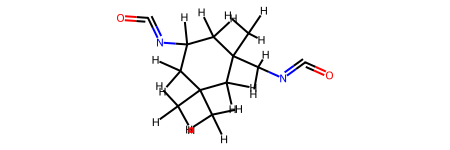

In [17]:
initial_reactants[0]